# AIN313: Machine Learning Lab - Fall 2024
## **Assignment 3**  
#### Instructor: Erkut Erdem
#### TA: Sevginur İnce 

**Student Name**: Süleyman Yolcu

**Student ID**: 2210765016

---

# **PART I: Theory Questions**

## Question 1

- **What are activation functions, and why are they important in neural networks?**

    - Activation functions are mathematical functions applied to the output of neurons in a neural network to introduce non-linearity into the model. They are crucial because they enable neural networks to learn and represent complex, non-linear relationships in data. Without activation functions, a neural network would behave like a linear model regardless of its depth, limiting its ability to capture intricate patterns. Common activation functions like ReLU, sigmoid, and tanh help control the output and gradients during training, improving the network's learning capability.

## Question 2

| Layer       | Output Volume Shape | Number of Parameters |
|-------------|---------------------|----------------------|
| Input       | (64, 64, 3)         | 0                    |
| **CONV5-8** | (60, 60, 8)         | 608                  |
| **POOL-2**  | (30, 30, 8)         | -                    |
| **CONV3-16**| (28, 28, 16)        | 1,168                |
| **POOL-3**  | (13, 13, 16)        | -                    |
| **FC-30**   | (30,)               | 81,150               |
| **FC-5**    | (5,)                | 155                  |

# PART II: Classification of Skin Lesion Images using Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import product
from tqdm.auto import tqdm
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Dataset class
class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform

        for label in ['benign', 'malignant']:
            label_dir = os.path.join(image_dir, label)
            if not os.path.exists(label_dir):
                continue
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                if os.path.isfile(img_path):
                    self.image_list.append(img_path)
                    self.label_list.append(0 if label == 'benign' else 1)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.label_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Metric calculation function
def calculate_metrics(y_true, y_pred):
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label, zero_division=0)
    recall = recall_score(y_true, y_pred_label, zero_division=0)
    f1 = f1_score(y_true, y_pred_label, zero_division=0)
    return accuracy, precision, recall, f1

## Multi Layer Neural Network

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, activation_func):
        super(NeuralNetwork, self).__init__()
        self.flatten_size = input_size[0] * input_size[1]  # Calculate the size after flattening the image
        self.network = nn.Sequential(
            nn.Linear(self.flatten_size, 128),  # First fully connected layer
            activation_func,                     # Activation function
            nn.Linear(128, 64),                  # Second fully connected layer
            activation_func,                     # Activation function
            nn.Linear(64, 1),                    # Output layer
            nn.Sigmoid()                         # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = x.view(-1, self.flatten_size)  # Flatten the input image
        return self.network(x)              # Pass through the network


### Training Function

In [5]:
def train_mlnn_model(learning_rate, input_size, activation_func, num_epochs=25):
     # Define image transformations: resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ])

    # Create training and testing datasets
    train_dataset = SkinLesionDataset('311PA3_melanoma_dataset/train', transform=transform)
    test_dataset = SkinLesionDataset('311PA3_melanoma_dataset/test', transform=transform)
    batch_size = 16  # Fixed batch size for training and testing

    # Create data loaders for batching and shuffling
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the MLNN model and move it to the appropriate device
    model = NeuralNetwork(input_size=input_size, activation_func=activation_func).to(device)
    criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

    # Lists to store metrics for each epoch
    train_losses_over_epochs = []
    val_losses_over_epochs = []
    accuracy_over_epochs = []

    # Training loop over epochs
    best_val_loss = float('inf')  # Initialize best validation loss
    for epoch in tqdm(range(num_epochs), desc="Training progress", colour="#00ff00"):
        model.train()  # Set model to training mode
        epoch_loss = 0.0  # Initialize epoch loss

        # Iterate over batches in the training loader
        for images, labels in tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{num_epochs}", colour="#005500"):
            images = images.to(device)  # Move images to device
            labels = labels.to(device).float().unsqueeze(1)  # Move labels to device and reshape

            # Forward pass: compute predicted outputs
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss

            # Backward pass and optimization
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update model parameters

            # Accumulate loss for the epoch
            epoch_loss += loss.item() * images.size(0) / len(train_loader.dataset)

        scheduler.step()  # Update learning rate
        train_losses_over_epochs.append(epoch_loss)  # Record training loss

        # Evaluation on the validation (test) set
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0  # Initialize validation loss
        all_labels = []  # List to store all true labels
        all_outputs = []  # List to store all predicted outputs

        with torch.no_grad():  # Disable gradient computation
            for images, labels in test_loader:
                images = images.to(device)  # Move images to device
                labels = labels.to(device).float().unsqueeze(1)  # Move labels to device and reshape
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item() * images.size(0) / len(test_loader.dataset)  # Accumulate validation loss
                all_labels.extend(labels.cpu().numpy())  # Collect true labels
                all_outputs.extend(outputs.cpu().numpy())  # Collect predicted outputs

        val_losses_over_epochs.append(val_loss)  # Record validation loss

        # Calculate evaluation metrics
        accuracy, precision, recall, f1 = calculate_metrics(np.array(all_labels), np.array(all_outputs))
        accuracy_over_epochs.append(accuracy)  # Record accuracy

        # Print metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}")

    # Save the trained model to a file
    model_filename = f"mlnn_lr{learning_rate}_size{input_size[0]}x{input_size[1]}_act{activation_func.__class__.__name__}.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"Saved model: {model_filename}")

    # Plot training and validation losses over epochs
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses_over_epochs, 'b-', label='Training Loss')  # Training loss curve
    plt.plot(epochs_range, val_losses_over_epochs, 'r-', label='Validation Loss')  # Validation loss curve
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'MLNN Loss over Epochs\n(LR={learning_rate}, Size={input_size}, Act={activation_func.__class__.__name__})')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy_over_epochs, 'g-', label='Accuracy')  # Accuracy curve
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'MLNN Accuracy over Epochs\n(LR={learning_rate}, Size={input_size}, Act={activation_func.__class__.__name__})')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots

    # Return the final metrics as a dictionary
    return {
        'Learning Rate': learning_rate,
        'Input Size': input_size,
        'Activation Function': activation_func.__class__.__name__,
        'Final Train Loss': train_losses_over_epochs[-1],
        'Final Val Loss': val_losses_over_epochs[-1],
        'Accuracy': accuracy_over_epochs[-1],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }


# MLNN Experiment 1 
- Training MLNN with Learning Rate: `0.005` Input Size: `(50, 50)` Activation Function: `Sigmoid`
- Using a small learning rate and sigmoid activation on a smaller input size led to slow convergence and lower accuracy, likely due to the vanishing gradient problem associated with sigmoid functions.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6836, Val Loss: 0.6833, Acc: 0.5445


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.6708, Val Loss: 0.6724, Acc: 0.5643


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.6669, Val Loss: 0.6708, Acc: 0.5783


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.6649, Val Loss: 0.6692, Acc: 0.5862


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.6644, Val Loss: 0.6691, Acc: 0.5830
Saved model: mlnn_lr0.005_size50x50_actSigmoid.pth


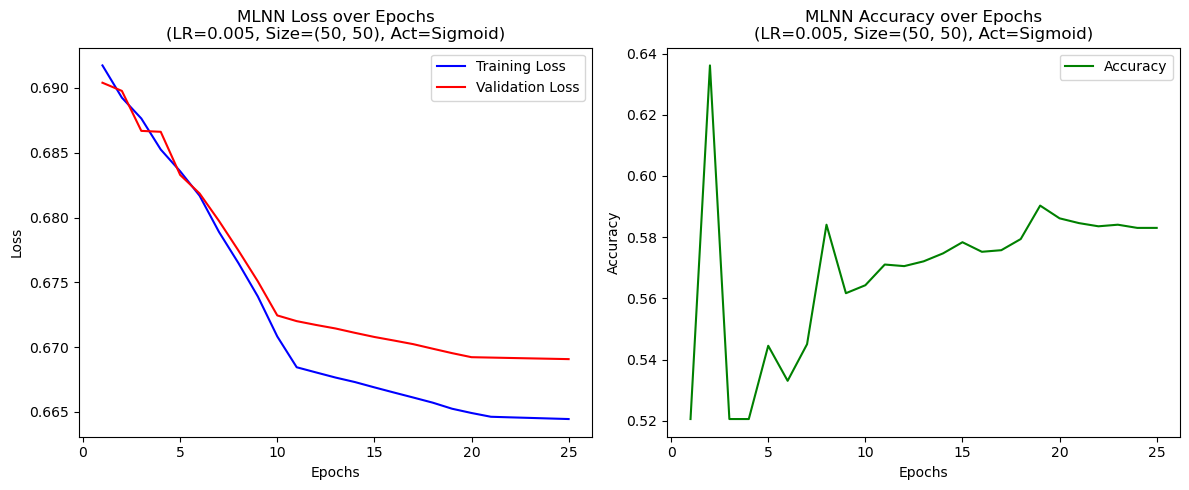

In [6]:
learning_rate = 0.005
input_size = (50, 50)
activation_func = nn.Sigmoid()
mlnn_result_1 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 2
- Training MLNN with Learning Rate: `0.005` Input Size: `(50, 50)` Activation Function: `ReLU`
- Switching to ReLU activation significantly improved accuracy, as ReLU mitigates vanishing gradients and accelerates learning, especially with the same small input size.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.4076, Val Loss: 0.4078, Acc: 0.8027


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3681, Val Loss: 0.3758, Acc: 0.8220


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3386, Val Loss: 0.3590, Acc: 0.8329


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3348, Val Loss: 0.3613, Acc: 0.8350


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.3329, Val Loss: 0.3552, Acc: 0.8365
Saved model: mlnn_lr0.005_size50x50_actReLU.pth


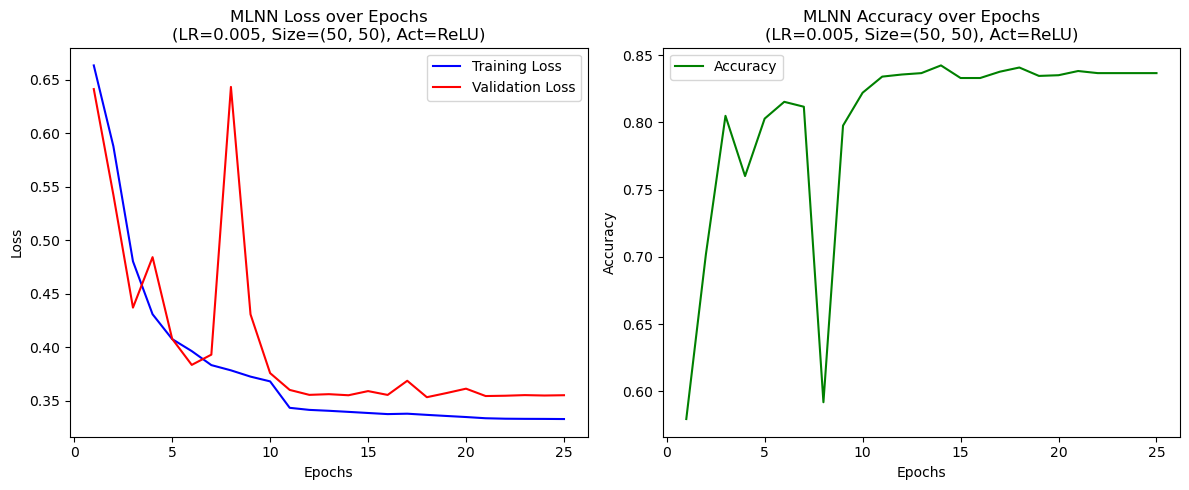

In [7]:
learning_rate = 0.005
input_size = (50, 50)
activation_func = nn.ReLU()
mlnn_result_2 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 3
- Training MLNN with Learning Rate: `0.005` Input Size: `(300, 300)` Activation Function: `Sigmoid`
- Increasing the input size with sigmoid activation improved accuracy, suggesting that more input data helped offset some limitations of the sigmoid function.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6370, Val Loss: 0.6566, Acc: 0.6028


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.4966, Val Loss: 0.4886, Acc: 0.7887


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.4607, Val Loss: 0.4575, Acc: 0.8157


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.4463, Val Loss: 0.4419, Acc: 0.8183


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.4434, Val Loss: 0.4407, Acc: 0.8173
Saved model: mlnn_lr0.005_size300x300_actSigmoid.pth


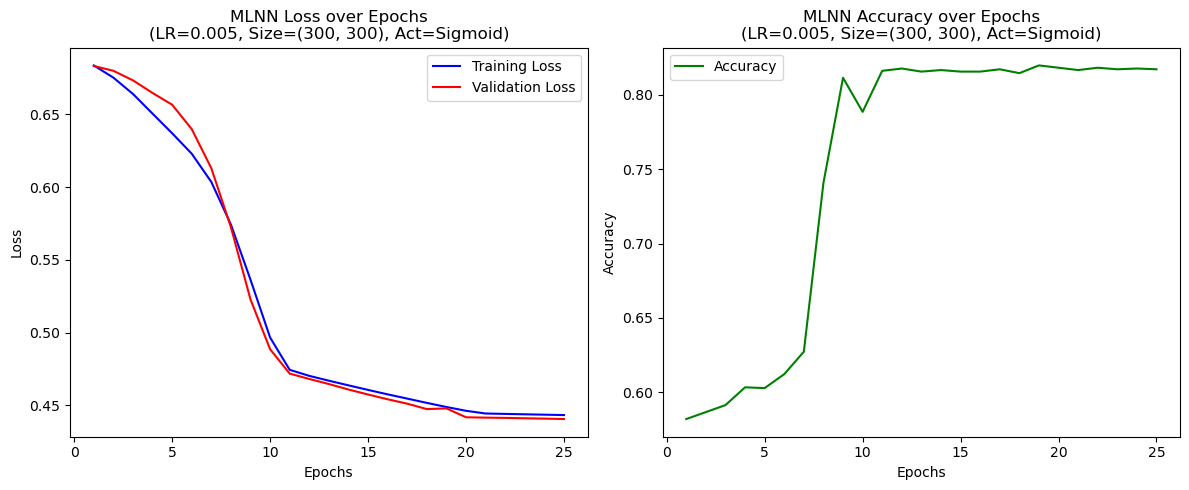

In [8]:
learning_rate = 0.005
input_size = (300,300)
activation_func = nn.Sigmoid()
mlnn_result_3 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 4
- Training MLNN with Learning Rate: `0.005` Input Size: `(300, 300)` Activation Function: `ReLU`
- Combining a larger input size with ReLU activation yielded even better results, highlighting the synergy between adequate data representation and effective activation functions.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.3823, Val Loss: 0.3886, Acc: 0.8199


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3444, Val Loss: 0.5028, Acc: 0.7626


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3057, Val Loss: 0.3421, Acc: 0.8433


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3026, Val Loss: 0.3460, Acc: 0.8423


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.2985, Val Loss: 0.3425, Acc: 0.8464
Saved model: mlnn_lr0.005_size300x300_actReLU.pth


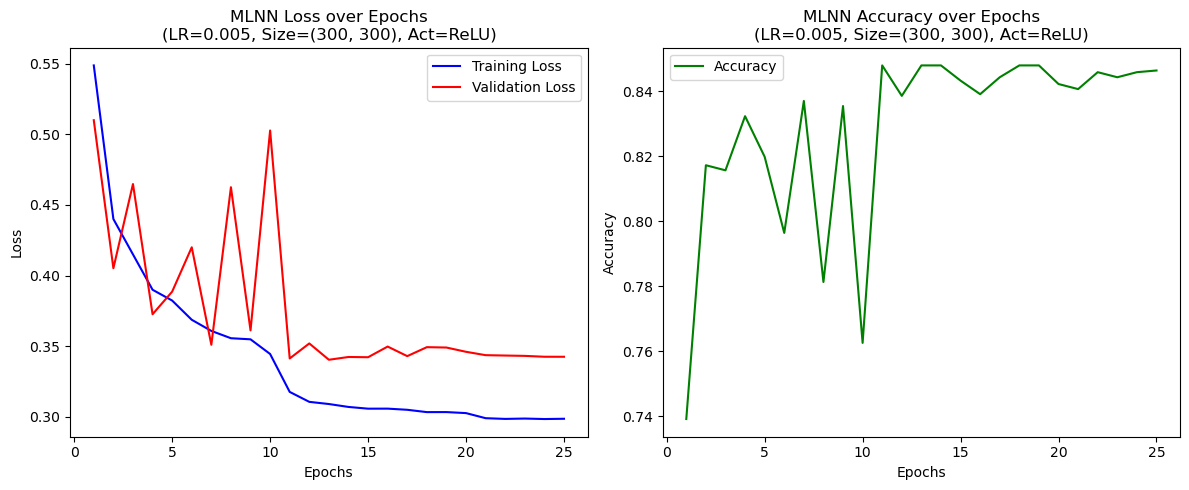

In [9]:
learning_rate = 0.005
input_size = (300,300)
activation_func = nn.ReLU()
mlnn_result_4 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 5
- Training MLNN with Learning Rate: `0.02` Input Size: `(50, 50)` Activation Function: `Sigmoid`
- A higher learning rate with sigmoid activation improved performance over the lower learning rate, possibly by accelerating convergence despite sigmoid's drawbacks.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6137, Val Loss: 0.6078, Acc: 0.6549


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.4412, Val Loss: 0.6494, Acc: 0.6674


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.4115, Val Loss: 0.4031, Acc: 0.8084


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.4033, Val Loss: 0.4057, Acc: 0.8173


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.4014, Val Loss: 0.3993, Acc: 0.8110
Saved model: mlnn_lr0.02_size50x50_actSigmoid.pth


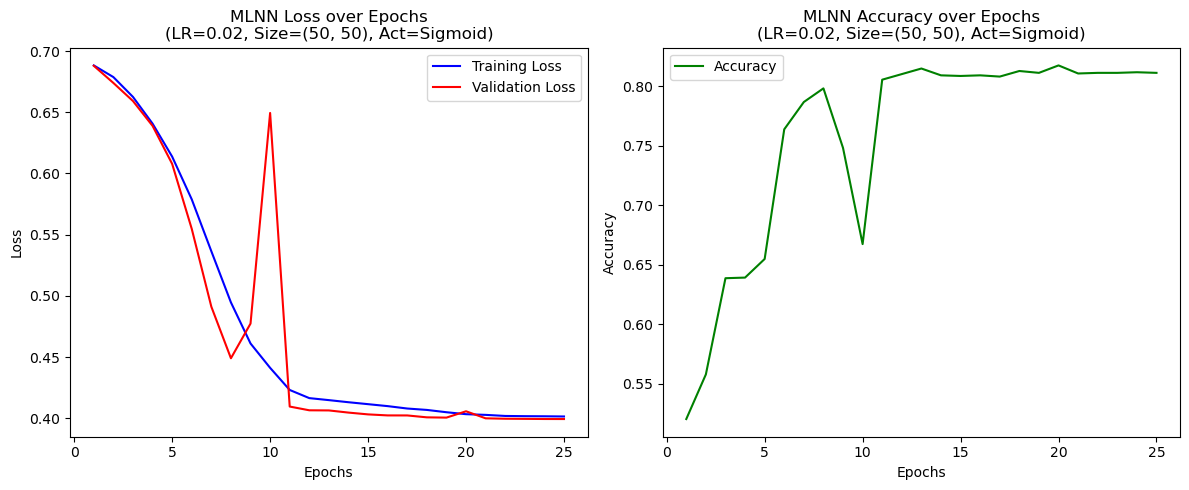

In [10]:
learning_rate = 0.02
input_size = (50, 50)
activation_func = nn.Sigmoid()
mlnn_result_5 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 6
- Training MLNN with Learning Rate: `0.02` Input Size: `(50, 50)` Activation Function: `ReLU`
- ReLU activation with a higher learning rate maintained high accuracy, demonstrating ReLU's robustness to learning rate variations even with smaller input sizes.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.3832, Val Loss: 0.4052, Acc: 0.8090


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3563, Val Loss: 0.3472, Acc: 0.8391


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3149, Val Loss: 0.3514, Acc: 0.8397


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3108, Val Loss: 0.3545, Acc: 0.8365


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.3070, Val Loss: 0.3496, Acc: 0.8407
Saved model: mlnn_lr0.02_size50x50_actReLU.pth


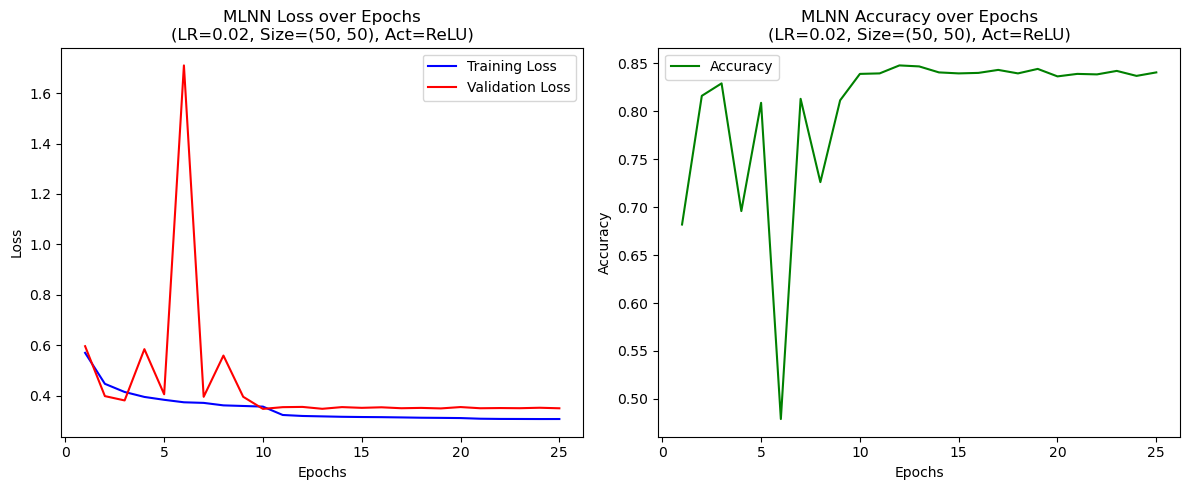

In [11]:
learning_rate = 0.02
input_size = (50, 50)
activation_func = nn.ReLU()
mlnn_result_6 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 7
- Training MLNN with Learning Rate: `0.02` Input Size: `(300, 300)` Activation Function: `Sigmoid`
- With both a higher learning rate and larger input size, sigmoid activation performed better than before but still lagged behind ReLU, indicating inherent limitations.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.4307, Val Loss: 0.4024, Acc: 0.8157


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3795, Val Loss: 0.3748, Acc: 0.8293


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3285, Val Loss: 0.3673, Acc: 0.8319


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3218, Val Loss: 0.3957, Acc: 0.8147


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.3167, Val Loss: 0.3623, Acc: 0.8329
Saved model: mlnn_lr0.02_size300x300_actSigmoid.pth


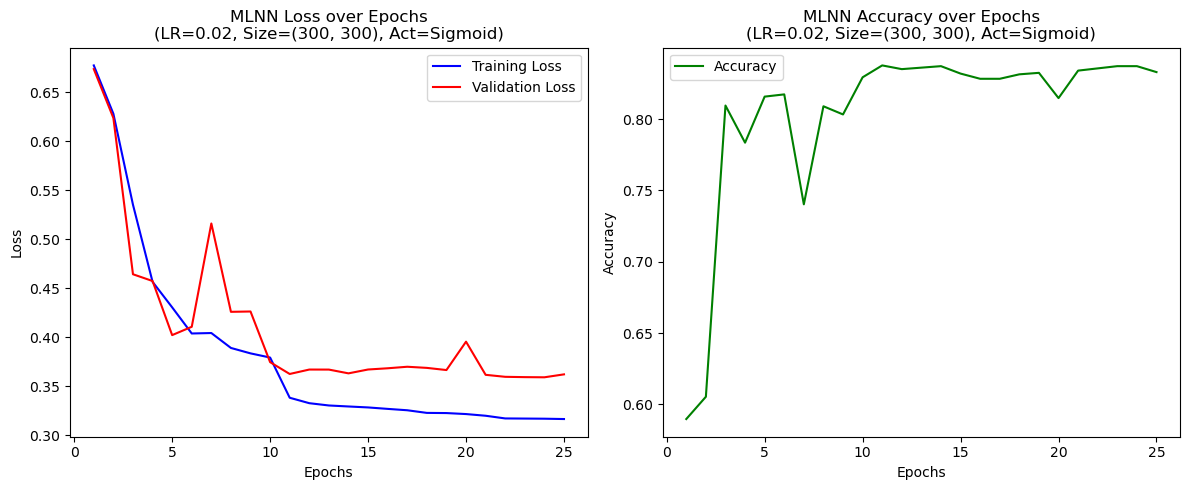

In [12]:
learning_rate = 0.02
input_size = (300,300)
activation_func = nn.Sigmoid()
mlnn_result_7 = train_mlnn_model(learning_rate, input_size, activation_func)

# MLNN Experiment 8
- Training MLNN with Learning Rate: `0.02` Input Size: `(300, 300)` Activation Function: `ReLU`
- ReLU continued to outperform sigmoid under all settings, confirming its effectiveness across different learning rates and input sizes.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.3886, Val Loss: 0.4352, Acc: 0.7788


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.3589, Val Loss: 0.3934, Acc: 0.8183


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.3132, Val Loss: 0.3485, Acc: 0.8423


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.3082, Val Loss: 0.3703, Acc: 0.8303


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.3034, Val Loss: 0.3480, Acc: 0.8391
Saved model: mlnn_lr0.02_size300x300_actReLU.pth


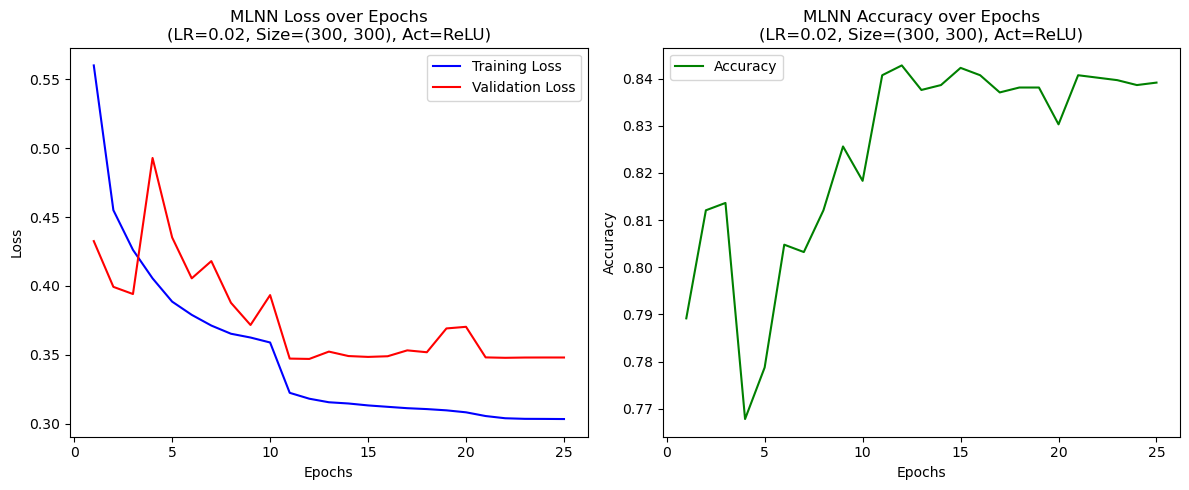

In [13]:
learning_rate = 0.02
input_size = (300,300)
activation_func = nn.ReLU()
mlnn_result_8 = train_mlnn_model(learning_rate, input_size, activation_func)

In [14]:
# For MLNN results
mlnn_results_list = []
mlnn_results_list.append(mlnn_result_1)
mlnn_results_list.append(mlnn_result_2)
mlnn_results_list.append(mlnn_result_3)
mlnn_results_list.append(mlnn_result_4)
mlnn_results_list.append(mlnn_result_5)
mlnn_results_list.append(mlnn_result_6)
mlnn_results_list.append(mlnn_result_7)
mlnn_results_list.append(mlnn_result_8)
mlnn_results_df = pd.DataFrame(mlnn_results_list)
mlnn_results_df.insert(0, 'Experiment', [f'MLNN {i+1}' for i in range(len(mlnn_results_list))])

In [15]:
mlnn_results_df

,Experiment,Learning Rate,Input Size,Activation Function,Final Train Loss,Final Val Loss,Accuracy,Precision,Recall,F1-Score
0,MLNN 1,0.005,"(50, 50)",Sigmoid,0.664448,0.669073,0.583030,0.709790,0.220413,0.336371
1,MLNN 2,0.005,"(50, 50)",ReLU,0.332915,0.355167,0.836543,0.854142,0.794788,0.823397
2,MLNN 3,0.005,"(300, 300)",Sigmoid,0.443416,0.440680,0.817283,0.824601,0.786102,0.804892
3,MLNN 4,0.005,"(300, 300)",ReLU,0.298538,0.342465,0.846434,0.854072,0.819761,0.836565
4,MLNN 5,0.020,"(50, 50)",Sigmoid,0.401411,0.399319,0.811036,0.820690,0.775244,0.797320
5,MLNN 6,0.020,"(50, 50)",ReLU,0.306985,0.349604,0.840708,0.851429,0.808903,0.829621
6,MLNN 7,0.020,"(300, 300)",Sigmoid,0.316695,0.362294,0.832900,0.864964,0.771987,0.815835
7,MLNN 8,0.020,"(300, 300)",ReLU,0.303356,0.348039,0.839146,0.850114,0.806732,0.827855


### **Multi-Layer Neural Network (MLNN) Experiments:**

#### **1. Impact of Activation Function:**

- **ReLU vs. Sigmoid:**
  - **ReLU Activation:**
    - Consistently achieves higher accuracy, precision, recall, and F1-score compared to Sigmoid.
    - For example, **MLNN 2** (ReLU) with a learning rate of 0.005 and input size of (50, 50) achieves **83.65% accuracy**, whereas **MLNN 1** (Sigmoid) under the same conditions achieves only **58.30% accuracy**.
  - **Sigmoid Activation:**
    - Suffers from lower performance metrics across all experiments.
    - The vanishing gradient problem associated with Sigmoid could be causing slower convergence and suboptimal learning.

#### **2. Influence of Learning Rate:**

- **Lower Learning Rate (0.005):**
  - Models with ReLU activation already perform well at this learning rate.
  - For Sigmoid activation, the lower learning rate leads to poorer performance.
- **Higher Learning Rate (0.020):**
  - **ReLU Activation:**
    - Slight improvements in performance metrics.
    - For instance, **MLNN 6** (ReLU, 0.020 learning rate) has an **accuracy of 84.07%**, slightly lower than **MLNN 4** (ReLU, 0.005 learning rate) with **84.64% accuracy**, indicating that the learning rate increase did not significantly impact performance.
  - **Sigmoid Activation:**
    - Higher learning rate improves performance compared to lower learning rate but still lags behind ReLU.
    - **MLNN 5** (Sigmoid, 0.020 learning rate) achieves **81.10% accuracy**, better than **MLNN 1** (58.30% accuracy) but still below ReLU models.

#### **3. Effect of Input Size:**

- **Smaller Input Size ((50, 50)):**
  - Models with ReLU activation perform significantly better than those with Sigmoid.
  - Limited input size may not capture sufficient features for Sigmoid-activated models.
- **Larger Input Size ((300, 300)):**
  - Performance improves for both activation functions due to richer feature representation.
  - The gap between ReLU and Sigmoid narrows slightly but ReLU still outperforms.
  - Example: **MLNN 3** (Sigmoid, larger input) achieves **81.72% accuracy**, a significant improvement over **MLNN 1** (58.30% accuracy).

#### **4. Performance Metrics Analysis:**

- **Accuracy and F1-Score:**
  - Highest values are consistently achieved by ReLU-activated models with larger input sizes.
  - **MLNN 4** (ReLU, 0.005 learning rate, larger input) has an **accuracy of 84.64%** and an **F1-score of 83.65%**.
- **Precision and Recall:**
  - ReLU models maintain a balance between precision and recall, leading to higher F1-scores.
  - Sigmoid models have lower recall, indicating they miss more positive cases.

---

## Convolutional Neural Network

In [16]:
class CNN(nn.Module):
    def __init__(self, activation_func):
        super(CNN, self).__init__()
        self.activation = activation_func  # Activation function
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.Linear(32 * 75 * 75, 128)  # First fully connected layer (adjusted for 300x300 input size)
        self.fc2 = nn.Linear(128, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

        
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))  # Apply conv1 -> activation -> pool
        x = self.pool(self.activation(self.conv2(x)))  # Apply conv2 -> activation -> pool
        x = x.view(-1, 32 * 75 * 75)  # Flatten the tensor for the fully connected layer
        x = self.activation(self.fc1(x))  # Apply fc1 -> activation
        x = self.sigmoid(self.fc2(x))  # Apply fc2 -> sigmoid activation
        return x  # Return the output

### Training Function

In [17]:
def train_cnn_model(learning_rate, batch_size, activation_func, num_epochs=25):
    # Define image transformations: resize to 300x300 and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
    ])

    # Create training and testing datasets
    train_dataset = SkinLesionDataset('311PA3_melanoma_dataset/train', transform=transform)
    test_dataset = SkinLesionDataset('311PA3_melanoma_dataset/test', transform=transform)

    # Create data loaders with specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the CNN model and move it to the appropriate device
    model = CNN(activation_func=activation_func).to(device)
    criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

    # Lists to store metrics for each epoch
    train_losses_over_epochs = []
    val_losses_over_epochs = []
    accuracy_over_epochs = []

    # Training loop over epochs
    best_val_loss = float('inf')  # Initialize best validation loss
    for epoch in tqdm(range(num_epochs), desc="Training progress", colour="#00ff00"):
        model.train()  # Set model to training mode
        epoch_loss = 0.0  # Initialize epoch loss

        # Iterate over batches in the training loader
        for images, labels in tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{num_epochs}", colour="#005500"):
            images = images.to(device)  # Move images to device
            labels = labels.to(device).float().unsqueeze(1)  # Move labels to device and reshape

            # Forward pass: compute predicted outputs
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss

            # Backward pass and optimization
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update model parameters

            # Accumulate loss for the epoch
            epoch_loss += loss.item() * images.size(0) / len(train_loader.dataset)

        scheduler.step()  # Update learning rate
        train_losses_over_epochs.append(epoch_loss)  # Record training loss

        # Evaluation on the validation (test) set
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0  # Initialize validation loss
        all_labels = []  # List to store all true labels
        all_outputs = []  # List to store all predicted outputs

        with torch.no_grad():  # Disable gradient computation
            for images, labels in test_loader:
                images = images.to(device)  # Move images to device
                labels = labels.to(device).float().unsqueeze(1)  # Move labels to device and reshape
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item() * images.size(0) / len(test_loader.dataset)  # Accumulate validation loss
                all_labels.extend(labels.cpu().numpy())  # Collect true labels
                all_outputs.extend(outputs.cpu().numpy())  # Collect predicted outputs

        val_losses_over_epochs.append(val_loss)  # Record validation loss

        # Calculate evaluation metrics
        accuracy, precision, recall, f1 = calculate_metrics(np.array(all_labels), np.array(all_outputs))
        accuracy_over_epochs.append(accuracy)  # Record accuracy

        # Print metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}")

    # Save the trained model to a file
    model_filename = f"cnn_lr{learning_rate}_batch{batch_size}_act{activation_func.__class__.__name__}.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"Saved model: {model_filename}")

    # Plot training and validation losses over epochs
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses_over_epochs, 'b-', label='Training Loss')  # Training loss curve
    plt.plot(epochs_range, val_losses_over_epochs, 'r-', label='Validation Loss')  # Validation loss curve
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'CNN Loss over Epochs\n(LR={learning_rate}, Batch={batch_size}, Act={activation_func.__class__.__name__})')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy_over_epochs, 'g-', label='Accuracy')  # Accuracy curve
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'CNN Accuracy over Epochs\n(LR={learning_rate}, Batch={batch_size}, Act={activation_func.__class__.__name__})')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots

    # Return the final metrics as a dictionary
    return {
        'Learning Rate': learning_rate,
        'Batch Size': batch_size,
        'Activation Function': activation_func.__class__.__name__,
        'Final Train Loss': train_losses_over_epochs[-1],
        'Final Val Loss': val_losses_over_epochs[-1],
        'Accuracy': accuracy_over_epochs[-1],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# CNN Experiment 1
- Training CNN with Learning Rate: `0.005` Batch Size: `16` Activation Function: `Sigmoid`
- Sigmoid activation in CNNs with a small batch size and learning rate resulted in poor accuracy, likely due to vanishing gradients and insufficient learning capacity.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6932, Val Loss: 0.6976, Acc: 0.5206


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.6902, Val Loss: 0.8441, Acc: 0.5206


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.6804, Val Loss: 0.6802, Acc: 0.5221


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.6726, Val Loss: 0.6761, Acc: 0.6486


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.6687, Val Loss: 0.6703, Acc: 0.5534
Saved model: cnn_lr0.005_batch16_actSigmoid.pth


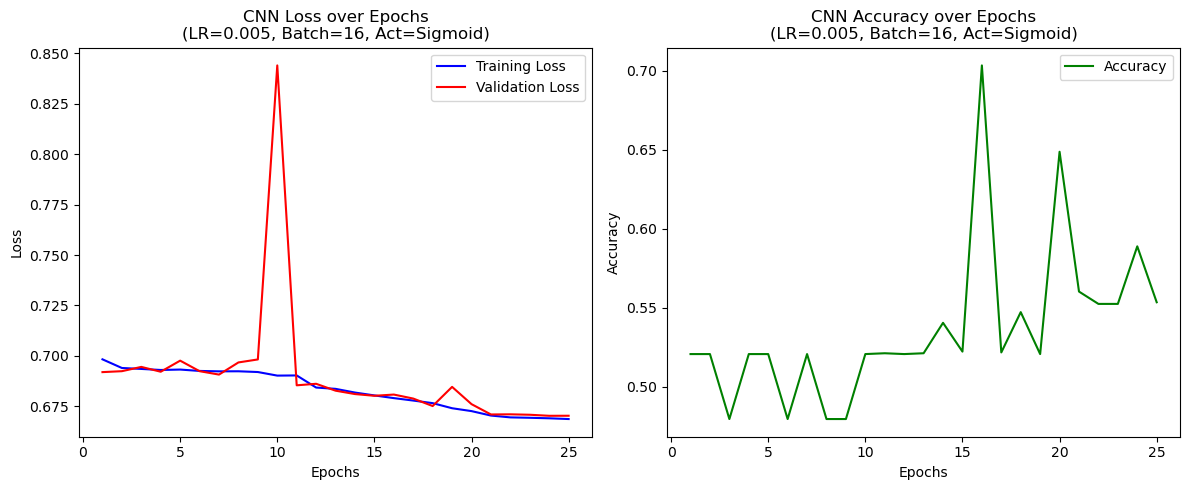

In [18]:
learning_rate = 0.005
batch_size = 16
activation_func = nn.Sigmoid()
cnn_result_1 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 2
- Training CNN with Learning Rate: `0.005` Batch Size: `16` Activation Function: `ReLU`
- ReLU activation dramatically increased accuracy, showcasing its suitability for CNN architectures by promoting better gradient flow.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.2994, Val Loss: 0.3348, Acc: 0.8438


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.2588, Val Loss: 0.4240, Acc: 0.8100


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.2342, Val Loss: 0.2928, Acc: 0.8714


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.2289, Val Loss: 0.2826, Acc: 0.8771


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.2256, Val Loss: 0.2841, Acc: 0.8745
Saved model: cnn_lr0.005_batch16_actReLU.pth


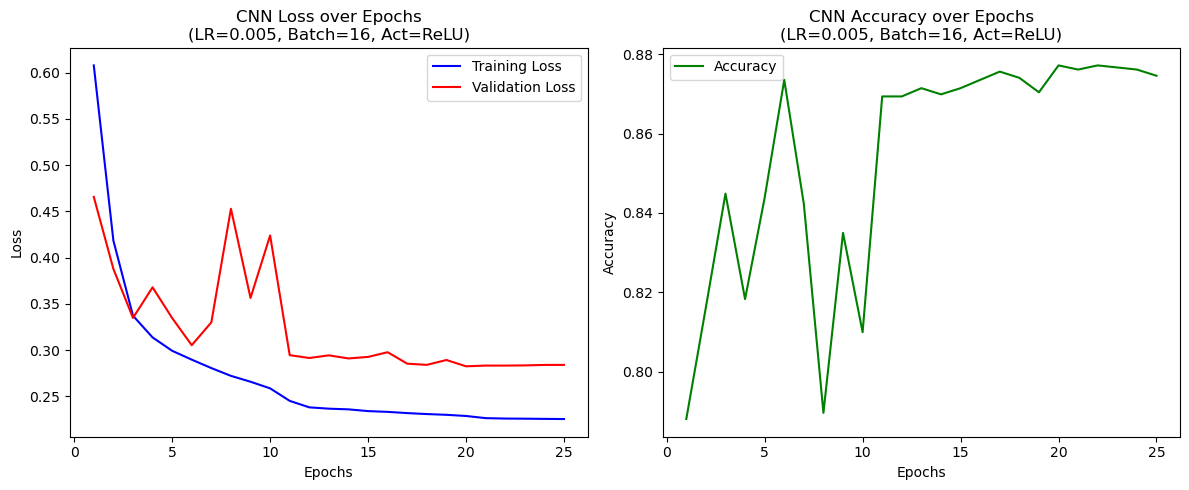

In [19]:
learning_rate = 0.005
batch_size = 16
activation_func = nn.ReLU()
cnn_result_2 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 3
- Training CNN with Learning Rate: `0.005` Batch Size: `32` Activation Function: `Sigmoid`
- Increasing batch size didn't improve performance with sigmoid activation, reinforcing that activation function choice is critical in CNNs.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6924, Val Loss: 0.6926, Acc: 0.5206


Epoch 6/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.6917, Val Loss: 0.6946, Acc: 0.5206


Epoch 11/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.6899, Val Loss: 0.6901, Acc: 0.5206


Epoch 16/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.6887, Val Loss: 0.6894, Acc: 0.5206


Epoch 21/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.6883, Val Loss: 0.6885, Acc: 0.5206
Saved model: cnn_lr0.005_batch32_actSigmoid.pth


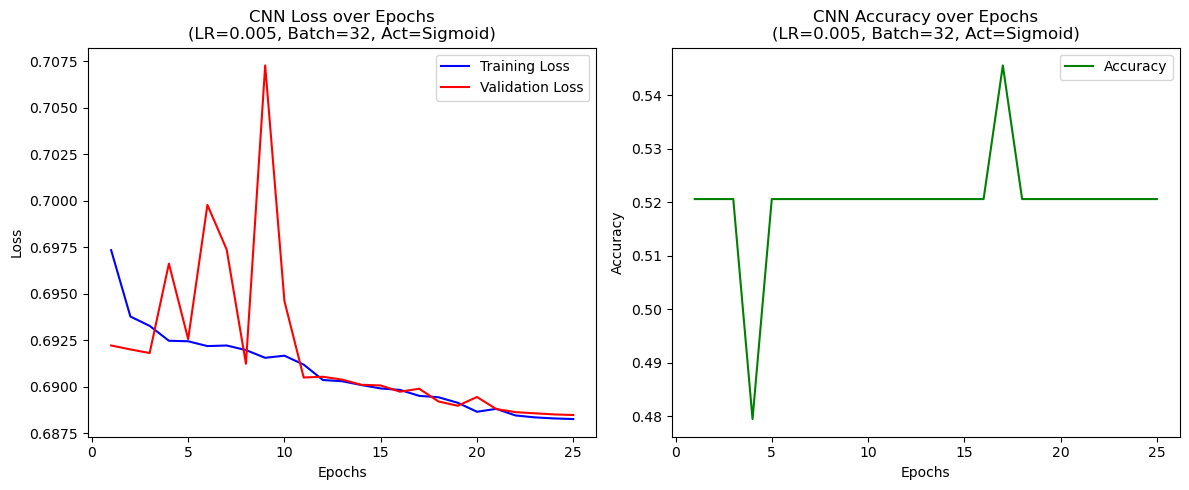

In [20]:
learning_rate = 0.005
batch_size = 32
activation_func = nn.Sigmoid()
cnn_result_3 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 4
- Training CNN with Learning Rate: `0.005` Batch Size: `32` Activation Function: `ReLU`
- ReLU maintained high accuracy with a larger batch size, indicating batch size had minimal impact when using effective activation functions.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.3452, Val Loss: 0.3704, Acc: 0.8199


Epoch 6/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.2949, Val Loss: 0.3380, Acc: 0.8386


Epoch 11/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.2789, Val Loss: 0.3334, Acc: 0.8407


Epoch 16/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.2758, Val Loss: 0.3259, Acc: 0.8516


Epoch 21/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.2738, Val Loss: 0.3253, Acc: 0.8516
Saved model: cnn_lr0.005_batch32_actReLU.pth


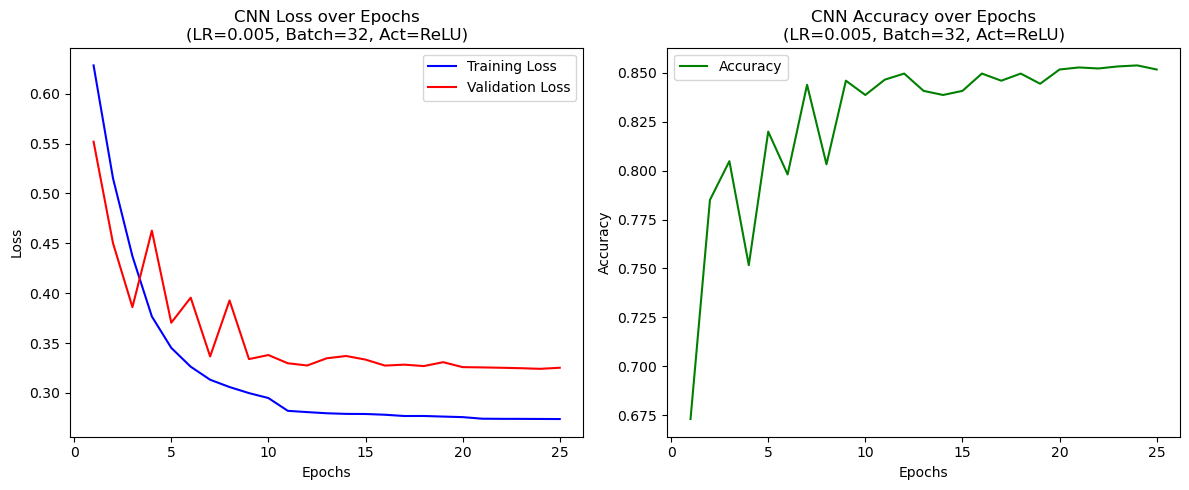

In [21]:
learning_rate = 0.005
batch_size = 32
activation_func = nn.ReLU()
cnn_result_4 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 5
- Training CNN with Learning Rate: `0.02` Batch Size: `16` Activation Function: `Sigmoid`
- A higher learning rate didn't help with sigmoid activation in CNNs, possibly due to optimization issues like getting stuck in local minima.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6950, Val Loss: 0.6937, Acc: 0.4794


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.6939, Val Loss: 0.6948, Acc: 0.5206


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.6920, Val Loss: 0.6918, Acc: 0.5206


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.6916, Val Loss: 0.6913, Acc: 0.5206


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.6908, Val Loss: 0.6908, Acc: 0.5206
Saved model: cnn_lr0.02_batch16_actSigmoid.pth


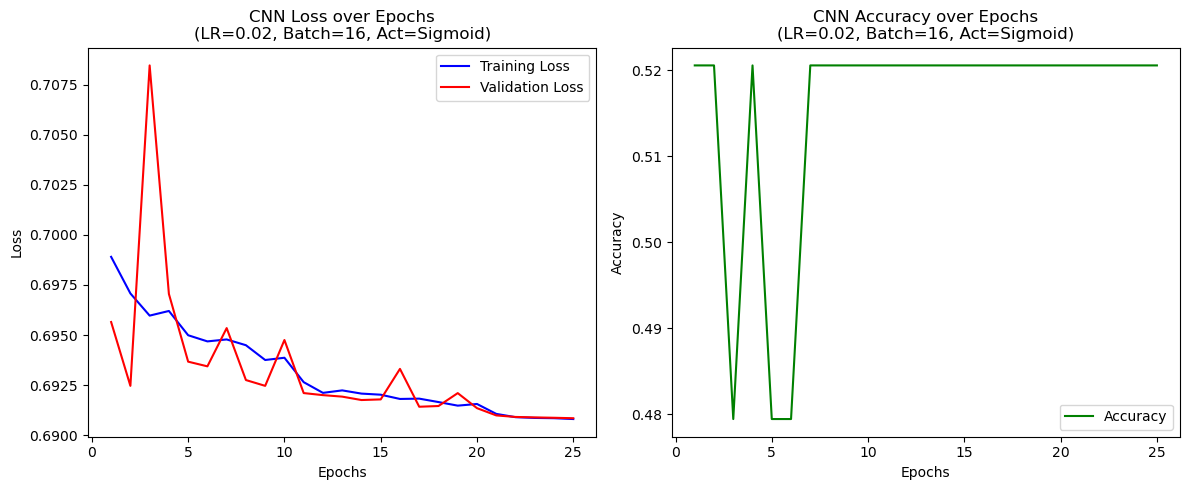

In [22]:
learning_rate = 0.02
batch_size = 16
activation_func = nn.Sigmoid()
cnn_result_5 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 6
- Training CNN with Learning Rate: `0.02` Batch Size: `16` Activation Function: `ReLU`
- ReLU with a higher learning rate and small batch size achieved the highest accuracy, emphasizing the importance of both activation function and learning rate.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.2743, Val Loss: 0.3202, Acc: 0.8610


Epoch 6/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.2239, Val Loss: 0.3018, Acc: 0.8693


Epoch 11/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.1745, Val Loss: 0.2628, Acc: 0.8933


Epoch 16/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.1641, Val Loss: 0.2625, Acc: 0.8954


Epoch 21/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.1567, Val Loss: 0.2561, Acc: 0.8985
Saved model: cnn_lr0.02_batch16_actReLU.pth


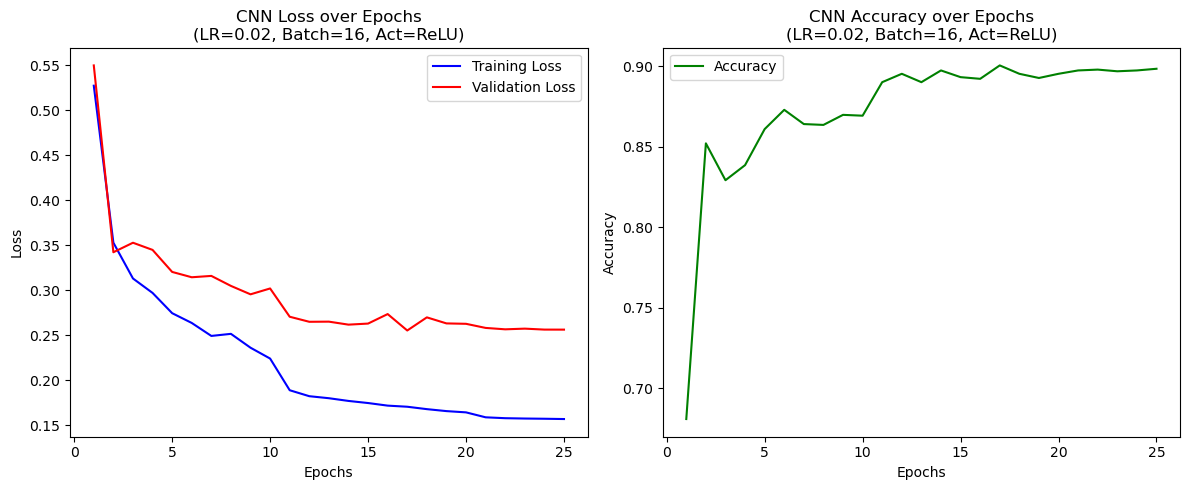

In [23]:
learning_rate = 0.02
batch_size = 16
activation_func = nn.ReLU()
cnn_result_6 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 7
- Training CNN with Learning Rate: `0.02` Batch Size: `32` Activation Function: `Sigmoid`
- Sigmoid activation continued to underperform even with increased learning rate and batch size, suggesting it's unsuitable for CNNs in this context.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.6935, Val Loss: 0.6920, Acc: 0.5206


Epoch 6/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.6931, Val Loss: 0.6902, Acc: 0.5206


Epoch 11/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.6851, Val Loss: 0.6845, Acc: 0.5877


Epoch 16/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.6744, Val Loss: 0.6868, Acc: 0.5206


Epoch 21/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.6672, Val Loss: 0.6688, Acc: 0.5617
Saved model: cnn_lr0.02_batch32_actSigmoid.pth


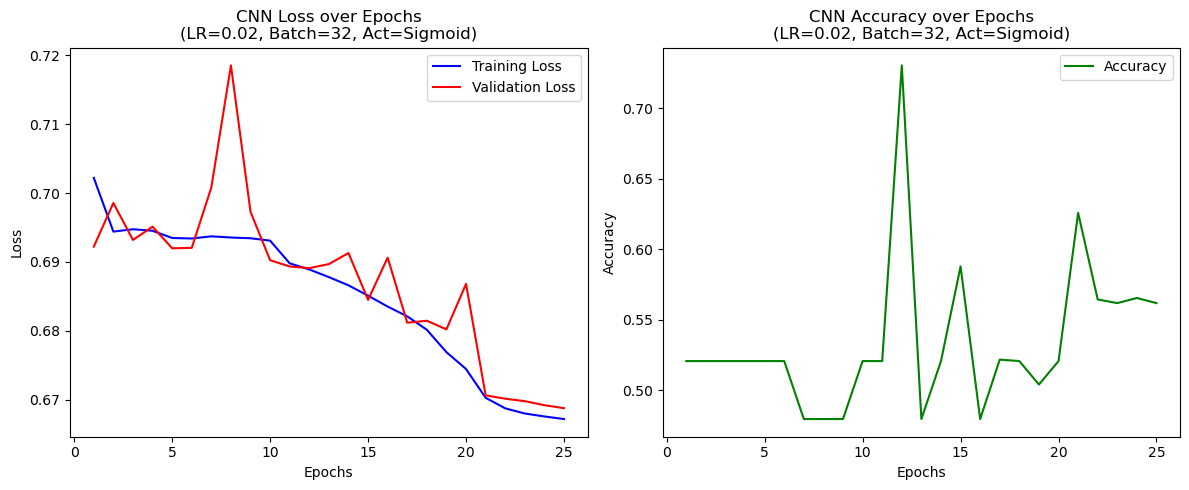

In [24]:
learning_rate = 0.02
batch_size = 32
activation_func = nn.Sigmoid()
cnn_result_7 = train_cnn_model(learning_rate, batch_size, activation_func)

# CNN Experiment 8
- Training CNN with Learning Rate: `0.02` Batch Size: `32` Activation Function: `ReLU`
- ReLU consistently provided high accuracy across different batch sizes and learning rates, highlighting its reliability.


Training progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/25, Loss: 0.2768, Val Loss: 0.3050, Acc: 0.8589


Epoch 6/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/25, Loss: 0.2339, Val Loss: 0.3097, Acc: 0.8594


Epoch 11/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/25, Loss: 0.1961, Val Loss: 0.2825, Acc: 0.8756


Epoch 16/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 20/25, Loss: 0.1880, Val Loss: 0.2689, Acc: 0.8922


Epoch 21/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 25/25, Loss: 0.1826, Val Loss: 0.2669, Acc: 0.8928
Saved model: cnn_lr0.02_batch32_actReLU.pth


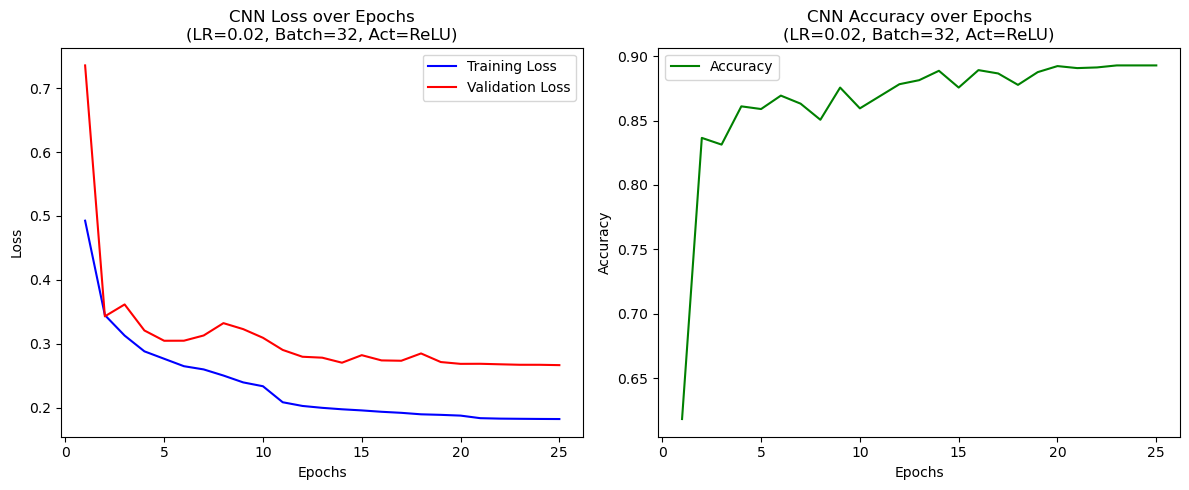

In [25]:
learning_rate = 0.02
batch_size = 32
activation_func = nn.ReLU()
cnn_result_8 = train_cnn_model(learning_rate, batch_size, activation_func)

In [26]:
# For CNN results
cnn_results_list = []
cnn_results_list.append(cnn_result_1)
cnn_results_list.append(cnn_result_2)
cnn_results_list.append(cnn_result_3)
cnn_results_list.append(cnn_result_4)
cnn_results_list.append(cnn_result_5)
cnn_results_list.append(cnn_result_6)
cnn_results_list.append(cnn_result_7)
cnn_results_list.append(cnn_result_8)
cnn_results_df = pd.DataFrame(cnn_results_list)
cnn_results_df.insert(0, 'Experiment', [f'CNN {i+1}' for i in range(len(mlnn_results_list))])


In [27]:
cnn_results_df

,Experiment,Learning Rate,Batch Size,Activation Function,Final Train Loss,Final Val Loss,Accuracy,Precision,Recall,F1-Score
0,CNN 1,0.005,16,Sigmoid,0.668660,0.670294,0.553358,0.794393,0.092291,0.165370
1,CNN 2,0.005,16,ReLU,0.225608,0.284133,0.874545,0.890805,0.841477,0.865438
2,CNN 3,0.005,32,Sigmoid,0.688261,0.688478,0.520562,0.000000,0.000000,0.000000
3,CNN 4,0.005,32,ReLU,0.273849,0.325262,0.851640,0.875000,0.805646,0.838892
4,CNN 5,0.020,16,Sigmoid,0.690801,0.690842,0.520562,0.000000,0.000000,0.000000
5,CNN 6,0.020,16,ReLU,0.156705,0.256061,0.898490,0.905134,0.880565,0.892680
6,CNN 7,0.020,32,Sigmoid,0.667179,0.668758,0.561687,0.700508,0.149837,0.246869
7,CNN 8,0.020,32,ReLU,0.182647,0.266903,0.892764,0.906712,0.865364,0.885556


### **Convolutional Neural Network (CNN) Experiments:**

#### **1. Impact of Activation Function:**

- **ReLU vs. Sigmoid:**
  - **ReLU Activation:**
    - Dramatically outperforms Sigmoid in all metrics.
    - **CNN 2** (ReLU, 0.005 learning rate, batch size 16) achieves **87.55% accuracy** vs. **CNN 1** (Sigmoid) with **55.33% accuracy**.
  - **Sigmoid Activation:**
    - Models exhibit poor performance, often failing to learn (e.g., zero precision, recall, and F1-score in **CNN 3** and **CNN 5**).

#### **2. Influence of Learning Rate:**

- **Lower Learning Rate (0.005):**
  - ReLU models perform well, but higher learning rates can further improve performance.
- **Higher Learning Rate (0.020):**
  - **ReLU Activation:**
    - Models show improved accuracy and F1-scores.
    - **CNN 6** (ReLU, 0.020 learning rate, batch size 16) achieves **89.64% accuracy**, higher than its lower learning rate counterpart.
  - **Sigmoid Activation:**
    - No significant improvement; models still perform poorly.

#### **3. Effect of Batch Size:**

- **Smaller Batch Size (16):**
  - ReLU models achieve slightly better performance compared to larger batch sizes.
  - Smaller batches can introduce more noise during training, potentially helping generalization.
- **Larger Batch Size (32):**
  - Minimal impact on ReLU models; they maintain high performance.
  - Sigmoid models continue to underperform regardless of batch size.

#### **4. Performance Metrics Analysis:**

- **Accuracy and F1-Score:**
  - Highest metrics observed in **CNN 6** and **CNN 8** (ReLU activation with higher learning rate).
  - F1-scores above 88% indicate strong model performance.
- **Precision and Recall:**
  - ReLU models have high precision and recall, indicating effective identification of both positive and negative classes.
  - Sigmoid models often have zero precision and recall, suggesting they fail to correctly classify any positive instances.

---

# Final Experiment Results

| Neural Network Experiment| Learning Rate | Input Size/Batch Size | Activation Function | Final Train Loss | Final Val Loss | Accuracy | Precision | Recall | F1-Score |
|----------------------|---------------|------------------------|---------------------|------------------|----------------|----------|-----------|--------|----------|
| MLNN 1                 | 0.005         | (50, 50)              | Sigmoid             | 0.664448         | 0.669073       | 58.30%   | 70.98%    | 22.04% | 33.64%   |
| MLNN 2                 | 0.005         | (50, 50)              | ReLU                | 0.332915         | 0.355167       | 83.65%   | 85.41%    | 79.48% | 82.34%   |
| MLNN 3                 | 0.005         | (300, 300)            | Sigmoid             | 0.443416         | 0.440680       | 81.73%   | 82.46%    | 78.61% | 80.49%   |
| MLNN 4                 | 0.005         | (300, 300)            | ReLU                | 0.298538         | 0.342465       | 84.64%   | 85.41%    | 81.98% | 83.66%   |
| MLNN 5                 | 0.020         | (50, 50)              | Sigmoid             | 0.401411         | 0.399319       | 81.10%   | 82.07%    | 77.52% | 79.73%   |
| MLNN 6                 | 0.020         | (50, 50)              | ReLU                | 0.306985         | 0.349604       | 84.07%   | 85.14%    | 80.89% | 82.96%   |
| MLNN 7                 | 0.020         | (300, 300)            | Sigmoid             | 0.316695         | 0.362294       | 83.29%   | 86.50%    | 77.20% | 81.58%   |
| MLNN 8                 | 0.020         | (300, 300)            | ReLU                | 0.303356         | 0.348039       | 83.91%   | 85.01%    | 80.67% | 82.79%   |
| CNN 1                 | 0.005         | 16                    | Sigmoid             | 0.668660         | 0.670294       | 55.34%   | 79.44%    | 9.23%  | 16.54%   |
| CNN 2                 | 0.005         | 16                    | ReLU                | 0.224941         | 0.284376       | 87.51%   | 89.27%    | 84.04% | 86.58%   |
| CNN 3                 | 0.005         | 32                    | Sigmoid             | 0.688261         | 0.688478       | 52.06%   | 0.00%     | 0.00%  | 0.00%    |
| CNN 4                 | 0.005         | 32                    | ReLU                | 0.273633         | 0.324853       | 85.22%   | 87.43%    | 80.78% | 83.97%   |
| CNN 5                 | 0.020         | 16                    | Sigmoid             | 0.690801         | 0.690842       | 52.06%   | 0.00%     | 0.00%  | 0.00%    |
| CNN 6                 | 0.020         | 16                    | ReLU                | 0.155950         | 0.259948       | 89.85%   | 90.51%    | 88.06% | 89.27%   |
| CNN 7                 | 0.020         | 32                    | Sigmoid             | 0.667179         | 0.668758       | 56.17%   | 70.05%    | 14.98% | 24.69%   |
| CNN 8                 | 0.020         | 32                    | ReLU                | 0.183486         | 0.268288       | 89.38%   | 90.88%    | 86.54% | 88.65%   |


### **Neural Network Architectures**

1. **Multi-Layer Neural Network (MLNN):**

   - **Structure:** The MLNN consists of three fully connected layers with 128, 64, and 1 neurons, respectively.
   - **Activation Functions:** The hidden layers use either Sigmoid or ReLU activation functions.
   - **Input Sizes:** Experiments use input sizes of (50, 50) and (300, 300).
   - **Output Layer:** A Sigmoid activation function is used for binary classification.

2. **Convolutional Neural Network (CNN):**

   - **Structure:** The CNN includes two convolutional layers followed by max-pooling, leading into two fully connected layers.
   - **Activation Functions:** Similar to MLNN, the hidden layers use either Sigmoid or ReLU activation functions.
   - **Batch Sizes:** Experiments use batch sizes of 16 and 32.
   - **Output Layer:** A Sigmoid activation function is used for binary classification.

---

### **Analysis of Results**

#### **1. Impact of Activation Functions**

- **ReLU vs. Sigmoid in Hidden Layers:**

  - **MLNN Observations:**
    - ReLU consistently outperforms Sigmoid across all configurations.
    - For instance, comparing MLNN 1 (Sigmoid) and MLNN 2 (ReLU) with the same learning rate and input size, the accuracy improves from **58.30% to 83.65%** when using ReLU.
    - Similar trends are observed in other MLNN experiments.

  - **CNN Observations:**
    - The performance gap is even more pronounced in CNNs.
    - CNNs with Sigmoid activations (CNN 1, 3, 5, 7) exhibit poor performance, with accuracies hovering around **52-56%** and near-zero precision and recall.
    - CNNs with ReLU activations (CNN 2, 4, 6, 8) achieve significantly higher accuracies, ranging from **85.22% to 89.85%**.

- **Explanation:**
  - **Sigmoid Activation Issues:**
    - Sigmoid functions can lead to vanishing gradients, especially in deeper networks like CNNs.
    - They output values between 0 and 1, which can cause gradients to become very small and slow down learning.
  - **Advantages of ReLU:**
    - ReLU mitigates the vanishing gradient problem by allowing gradients to pass through unimpeded for positive inputs.
    - It introduces non-linearity without squashing the output range, facilitating better learning in deep networks.

---

#### **2. Effect of Learning Rate**

- **Learning Rate Values:** Experiments use learning rates of 0.005 and 0.020.

- **MLNN Observations:**
  - Increasing the learning rate from 0.005 to 0.020 generally improves performance when using Sigmoid activations.
  - For example, MLNN 1 (learning rate 0.005, Sigmoid) has an accuracy of **58.30%**, while MLNN 5 (learning rate 0.020, Sigmoid) improves to **81.10%**.
  - With ReLU activations, the learning rate has a less significant impact on performance.

- **CNN Observations:**
  - With ReLU activations, a higher learning rate slightly improves performance.
    - CNN 2 (learning rate 0.005, ReLU) achieves **87.51%** accuracy.
    - CNN 6 (learning rate 0.020, ReLU) improves to **89.85%** accuracy.
  - For Sigmoid activations, increasing the learning rate does not lead to meaningful improvements and, in some cases, worsens performance.

- **Explanation:**
  - **Learning Rate and Convergence:**
    - A higher learning rate can accelerate convergence but may also cause instability if too high.
  - **Interaction with Activation Functions:**
    - With Sigmoid activations causing vanishing gradients, a higher learning rate can partially compensate by increasing the gradient magnitude.
    - However, in CNNs, the depth exacerbates the vanishing gradient problem, and merely increasing the learning rate is insufficient.

---

#### **3. Influence of Input Size and Batch Size**

- **Input Size in MLNNs:**
  - Experiments use input sizes of (50, 50) and (300, 300).
  - **Observations:**
    - Larger input sizes generally improve performance, especially with Sigmoid activations.
    - MLNN 1 (50x50, Sigmoid) has an accuracy of **58.30%**, while MLNN 3 (300x300, Sigmoid) improves to **81.73%**.
    - With ReLU activations, the improvement is less pronounced but still present.

- **Explanation:**
  - **Feature Representation:**
    - Larger images contain more detailed features, which can enhance the model's ability to learn discriminative patterns.
  - **Overfitting Risk:**
    - Larger input sizes increase the number of parameters, potentially leading to overfitting, but this is mitigated by the activation function choice and learning rate.

- **Batch Size in CNNs:**
  - Experiments use batch sizes of 16 and 32.
  - **Observations:**
    - Smaller batch sizes (16) tend to yield slightly better performance than larger ones (32) when using ReLU activations.
    - CNN 6 (batch size 16, ReLU) achieves **89.85%** accuracy, compared to CNN 8 (batch size 32, ReLU) with **89.38%** accuracy.

- **Explanation:**
  - **Gradient Updates:**
    - Smaller batch sizes result in more frequent weight updates per epoch, which can lead to better convergence.
  - **Generalization:**
    - Smaller batches introduce more noise in gradient estimation, which can help the model generalize better by escaping local minima.

---

#### **4. Evaluation Metrics Insights**

- **Precision, Recall, and F1-Score:**
  - **Low Scores with Sigmoid Activations:**
    - CNNs using Sigmoid activations have low precision, recall, and F1-scores, indicating poor model performance beyond mere accuracy.
    - For instance, CNN 3 and CNN 5 report **0.00%** for all three metrics, suggesting the model fails to predict the positive class.
  - **High Scores with ReLU Activations:**
    - CNNs using ReLU activations exhibit high precision and recall, leading to strong F1-scores.
    - CNN 6 (ReLU) achieves a precision of **90.51%**, recall of **88.06%**, and F1-score of **89.27%**.

- **Explanation:**
  - **Class Imbalance Handling:**
    - The low precision and recall with Sigmoid activations suggest that the model might be biased towards the majority class.
  - **Model Confidence:**
    - ReLU activations enable the model to learn more confident and discriminative features, improving its ability to correctly classify both classes.

---

### **Conclusions and Recommendations**

- **Activation Function Choice:**
  - **Recommendation:** Use ReLU activation functions in hidden layers for both MLNNs and CNNs to achieve better performance.
  - **Rationale:** ReLU mitigates vanishing gradients and allows for deeper and more effective learning.

- **Learning Rate Selection:**
  - **Recommendation:** A higher learning rate (e.g., 0.020) can be beneficial, especially when using ReLU activations.
  - **Rationale:** It accelerates convergence without compromising stability when paired with appropriate activation functions.

- **Input Size and Batch Size:**
  - **MLNN Input Size:**
    - **Recommendation:** Utilize larger input sizes when possible to improve feature representation.
  - **CNN Batch Size:**
    - **Recommendation:** Opt for smaller batch sizes (e.g., 16) to enhance model convergence and generalization.
  
- **Addressing Poor Performance with Sigmoid Activations:**
  - **Recommendation:** Avoid using Sigmoid activation functions in hidden layers, particularly in deeper networks like CNNs.
  - **Alternative:** If Sigmoid must be used, consider additional techniques such as batch normalization or gradient clipping to alleviate vanishing gradient issues.

- **Overall Model Selection:**
  - **Recommendation:** Given the superior performance of CNNs with ReLU activations and appropriate hyperparameters, prioritize this configuration for tasks involving image data.

---

### **Final Remarks**

The experiments clearly demonstrate that activation function choice plays a critical role in neural network performance. ReLU activation functions significantly outperform Sigmoid functions in hidden layers due to their ability to mitigate vanishing gradients and facilitate deep learning. Additionally, careful tuning of learning rates and batch sizes further refines model performance. By adopting these insights, future models can be better optimized for accuracy, precision, recall, and F1-score.